In [1]:
%matplotlib inline

import captest as pvc
from bokeh.io import output_notebook, show

#if working offline with the CapData.plot() method may fail
#run 'export BOKEH_RESOURCES=inline' at the command line before
#running the jupyter notebook

output_notebook()

Loading BokehJS ...

# Loading Measured and Simulated Data

CapData objects hold simulated data from PVsyst and measured data from a DAS or SCADA system and provide methods to load, organize, and visualize the data.

The load_data method by default attempts to infer the type of measurement and the type of sensor in each column.  For example, a measurement from a ambient temperature sensor would be categorized as 'temp-amb-'.  A python dictionary which translates from the column titles in the input file and the inferred type is created and saved to the CapData.trans attribute. This translation dictionary is used in the CapData.view and CapData.rview methods to easily access columns of data of a certain type without renaming columns.  This dictionary is used by methods of CapTest objects to aggregate sensors of the same type.

User input is required to set which inferred measurement type is the correct one for the regression variables. The CapData.set_reg_trans method is used to set this relationship.

In [2]:
das = pvc.CapData()

In [3]:
das.load_data()

Read: example_meas_data.csv
Skipped file: pvsyst_example_HourlyRes_2.CSV


In [4]:
das.trans

{'index--': ['index'],
 'irr-ghi-pyran': ['met1 ghi_pyranometer', 'met2 ghi_pyranometer'],
 'irr-mtr-pyran': ['met1 poa_pyranometer', 'met2 poa_pyranometer'],
 'irr-poa-ref_cell': ['met1 poa_refcell', 'met2 poa_refcell'],
 'real_pwr-inv-': ['inv1 power',
  'inv2 power',
  'inv3 power',
  'inv4 power',
  'inv5 power',
  'inv6 power',
  'inv7 power',
  'inv8 power'],
 'real_pwr-mtr-': ['meter power'],
 'temp-amb-': ['met1 amb_temp', 'met2 amb_temp'],
 'temp-mod-': ['met1 mod_temp1',
  'met1 mod_temp2',
  'met2 mod_temp1',
  'met2 mod_temp2'],
 'wind-valuesError--': ['met1 windspeed', 'met2 windspeed']}

In [5]:
das.set_reg_trans(power='real_pwr-mtr-', poa='irr-poa-ref_cell', t_amb='temp-amb-', w_vel='wind-valuesError--')

The CapData.plot method creates a group of time series plots that are useful for performing an initial visual inspection of the imported data.

The plots are structured around the translation dictionary groupings.  A single plot is generated for each different type of data (translation dictionary keys) and each column within that measurement type (translation dictionary values) is plotted as a separate series on the plot.  In this example there are two different weather stations, which each have pyranometers measuring plane of array and global horizontal irradiance. This arrangement of sensors results in two plots which each have two lines.

In [6]:
das.plot(marker='line')

In [7]:
sim = pvc.CapData()

In [8]:
sim.load_data(load_pvsyst=True)

Skipped file: example_meas_data.csv
Read: pvsyst_example_HourlyRes_2.CSV


In [9]:
sim.trans

{'--': ['IL Pmax', 'IL Pmin', 'IL Vmax', 'IL Vmin', 'TArray'],
 '-inv-': ['EOutInv'],
 'index--': ['index'],
 'irr-ghi-': ['GlobHor', 'GlobInc'],
 'real_pwr--': ['E_Grid'],
 'shade--': ['FShdBm'],
 'temp-amb-': ['TAmb'],
 'wind--': ['WindVel']}

In [10]:
sim.drop_cols(['GlobHor'])

In [11]:
sim.set_reg_trans(power='real_pwr--', poa='irr-ghi-', t_amb='temp-amb-', w_vel='wind--')

In [ ]:
# sim.plot()

# Performing Capacity Test

The CapTest object provides a framework that facilitates performing the steps of a capacity test following the ASTM standard. The methods of CapTest class provide convenient ways to perform various filtering steps, perform linear regressions, summarize the methods applied, calculate reporting conditions, and calculate the final results of a test.


A CapTest object must be initialized with two CapData objects: one containing measured data and one containing simulated data.  A tolerance for for the capacity test is also required.

In [12]:
cptest = pvc.CapTest(das, sim, 0.05)

### Analysis of PVsyst Data

In [14]:
# Write over cptest.flt_sim dataframe with a copy of the original unfiltered dataframe
# cptest.reset_flt('sim')

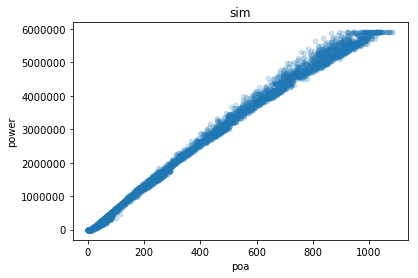

In [15]:
cptest.scatter('sim')

In [16]:
cptest.filter_irr('sim', 0, 900)
cptest.filter_irr('sim', 0.1, 900)
cptest.filter_irr('sim', 200, 900)

In [17]:
cptest.summary()

Timestamps  Timestamps_filtered     Filter_arguments
sim filter_irr        8377                  383    ('sim', 0, 900){}
    filter_irr        4124                 4253  ('sim', 0.1, 900){}
    filter_irr        2431                 1693  ('sim', 200, 900){}

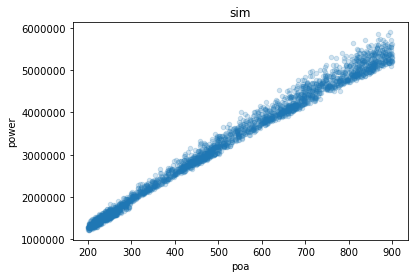

In [18]:
cptest.scatter('sim')

In [19]:
cptest.filter_time('sim', test_date='5/15/1990', days=60)

In [20]:
cptest.reg_cpt('sim', filter=True)

NOTE: Regression used to filter outlying points.


                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.725e+05
Date:                Mon, 18 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:27:29   Log-Likelihood:                -5321.5
No. Observations:                 447   AIC:                         1.065e+04
Df Residuals:                     443   BIC:                         1.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [21]:
cptest.filter_pvsyst('sim')

In [24]:
cptest.sim.df.index[0]

Timestamp('1990-01-01 00:00:00')

____
#### Calculation of Reporting Conditions from PVsyst Data

In [26]:
cptest.rep_cond('sim', test_date='5/15/1990', days=30)

Reporting conditions saved to rc attribute.
{'t_amb': [26.793518518518518], 'w_vel': [4.3722222222222236], 'poa': [581.69000000000005]}


----

In [27]:
cptest.filter_irr('sim', 0.5, 1.5, ref_val=cptest.rc['poa'][0])

In [28]:
cptest.reg_cpt('sim')

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.106e+06
Date:                Mon, 18 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:29:26   Log-Likelihood:                -3568.7
No. Observations:                 317   AIC:                             7145.
Df Residuals:                     313   BIC:                             7160.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
poa             7506.7240     14.459    519.

In [29]:
cptest.summary()

Timestamps  Timestamps_filtered  \
sim filter_irr           8377                  383   
    filter_irr           4124                 4253   
    filter_irr           2431                 1693   
    filter_time           447                 1984   
    reg_cpt               414                   33   
    filter_pvsyst         414                    0   
    rep_cond              414                    0   
    rep_cond              414                    0   
    filter_irr            317                   97   
    reg_cpt               317                    0   

                                                   Filter_arguments  
sim filter_irr                                    ('sim', 0, 900){}  
    filter_irr                                  ('sim', 0.1, 900){}  
    filter_irr                                  ('sim', 200, 900){}  
    filter_time      ('sim',){'days': 60, 'test_date': '5/15/1990'}  
    reg_cpt                                ('sim',){'filter': True}  
    filter_pvsyst                                        ('sim',){}  
    rep_cond                     ('sim',){'test_date': '5/15/1990'}  
    rep_cond         ('sim',){'days': 30, 'test_date': '5/15/1990'}  
    filter_irr     ('sim', 0.5, 1.5){'ref_val': 581.69000000000005}  
    reg_cpt                                              ('sim',){}

_____

### Analysis of Measured Data

In [70]:
cptest.reset_flt('das')

In [71]:
cptest.filter_sensors('das', skip_strs=['wind'])

In [72]:
cptest.filter_missing('das')

In [73]:
cptest.summary()

Timestamps  Timestamps_filtered  \
das filter_sensors         519                  921   
    filter_missing         519                    0   
sim filter_irr            8377                  383   
    filter_irr            4124                 4253   
    filter_irr            2431                 1693   
    filter_time            447                 1984   
    reg_cpt                414                   33   
    filter_pvsyst          414                    0   
    rep_cond               414                    0   
    rep_cond               414                    0   
    filter_irr             317                   97   
    reg_cpt                317                    0   

                                                    Filter_arguments  
das filter_sensors                   ('das',){'skip_strs': ['wind']}  
    filter_missing                                        ('das',){}  
sim filter_irr                                     ('sim', 0, 900){}  
    filter_irr                                   ('sim', 0.1, 900){}  
    filter_irr                                   ('sim', 200, 900){}  
    filter_time       ('sim',){'days': 60, 'test_date': '5/15/1990'}  
    reg_cpt                                 ('sim',){'filter': True}  
    filter_pvsyst                                         ('sim',){}  
    rep_cond                      ('sim',){'test_date': '5/15/1990'}  
    rep_cond          ('sim',){'days': 30, 'test_date': '5/15/1990'}  
    filter_irr      ('sim', 0.5, 1.5){'ref_val': 581.69000000000005}  
    reg_cpt                                               ('sim',){}

In [74]:
cptest.filter_outliers('das')

//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.234512976450645 > 37.687639769793911)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.349971825216869 > 37.875991272665857)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.328430150698360 > 37.779224324570350)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.275068665725705 > 37.649167045092469)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: Runtime

//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.347093883053347 > 38.027655727195011)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.234512976450645 > 37.876134538281477)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.340642198128492 > 37.875795902226159)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.234512976450645 > 37.910849014356579)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: Runtime

//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.327914720088600 > 37.653510425989971)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.360345580714814 > 37.895933340916855)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.343036203318817 > 37.895687100259508)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (39.358922114208568 > 37.874230496863959)
  % (det, previous_det), RuntimeWarning)
//anaconda/envs/pvc_env/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: Runtime

In [ ]:
# cptest.flt_das.plot(marker='line-circle')

In [75]:
cptest.agg_sensors('das', irr='mean')

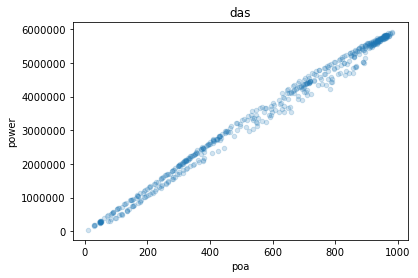

In [76]:
cptest.scatter('das')

In [77]:
cptest.reg_cpt('das', filter=True)

NOTE: Regression used to filter outlying points.


                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.472e+05
Date:                Mon, 18 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:58:50   Log-Likelihood:                -6501.5
No. Observations:                 498   AIC:                         1.301e+04
Df Residuals:                     494   BIC:                         1.303e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [78]:
cptest.summary()

Timestamps  Timestamps_filtered  \
das filter_sensors          519                  921   
    filter_missing          519                    0   
    filter_outliers         498                   21   
    reg_cpt                 478                   20   
sim filter_irr             8377                  383   
    filter_irr             4124                 4253   
    filter_irr             2431                 1693   
    filter_time             447                 1984   
    reg_cpt                 414                   33   
    filter_pvsyst           414                    0   
    rep_cond                414                    0   
    rep_cond                414                    0   
    filter_irr              317                   97   
    reg_cpt                 317                    0   

                                                     Filter_arguments  
das filter_sensors                    ('das',){'skip_strs': ['wind']}  
    filter_missing                                         ('das',){}  
    filter_outliers                                        ('das',){}  
    reg_cpt                                  ('das',){'filter': True}  
sim filter_irr                                      ('sim', 0, 900){}  
    filter_irr                                    ('sim', 0.1, 900){}  
    filter_irr                                    ('sim', 200, 900){}  
    filter_time        ('sim',){'days': 60, 'test_date': '5/15/1990'}  
    reg_cpt                                  ('sim',){'filter': True}  
    filter_pvsyst                                          ('sim',){}  
    rep_cond                       ('sim',){'test_date': '5/15/1990'}  
    rep_cond           ('sim',){'days': 30, 'test_date': '5/15/1990'}  
    filter_irr       ('sim', 0.5, 1.5){'ref_val': 581.69000000000005}  
    reg_cpt                                                ('sim',){}

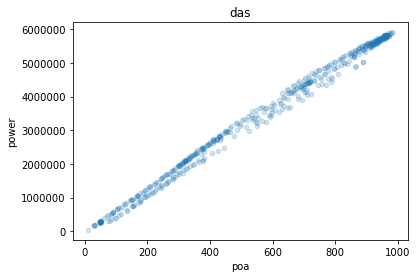

In [79]:
cptest.scatter('das')

In [80]:
cptest.filter_irr('das', 0.5, 1.5, ref_val=cptest.rc['poa'][0])

In [81]:
cptest.reg_cpt('das')

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.975e+04
Date:                Mon, 18 Jun 2018   Prob (F-statistic):               0.00
Time:                        16:59:20   Log-Likelihood:                -3265.6
No. Observations:                 252   AIC:                             6539.
Df Residuals:                     248   BIC:                             6553.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
poa             7951.3887     95.140     83.

In [91]:
cptest.summary()

Timestamps  Timestamps_filtered  \
das filter_sensors          519                  921   
    filter_missing          519                    0   
    filter_outliers         498                   21   
    reg_cpt                 478                   20   
    filter_irr              252                  226   
    reg_cpt                 252                    0   
sim filter_irr             8377                  383   
    filter_irr             4124                 4253   
    filter_irr             2431                 1693   
    filter_time             447                 1984   
    reg_cpt                 414                   33   
    filter_pvsyst           414                    0   
    rep_cond                414                    0   
    rep_cond                414                    0   
    filter_irr              317                   97   
    reg_cpt                 317                    0   

                                                     Filter_arguments  
das filter_sensors                    ('das',){'skip_strs': ['wind']}  
    filter_missing                                         ('das',){}  
    filter_outliers                                        ('das',){}  
    reg_cpt                                  ('das',){'filter': True}  
    filter_irr       ('das', 0.5, 1.5){'ref_val': 581.69000000000005}  
    reg_cpt                                                ('das',){}  
sim filter_irr                                      ('sim', 0, 900){}  
    filter_irr                                    ('sim', 0.1, 900){}  
    filter_irr                                    ('sim', 200, 900){}  
    filter_time        ('sim',){'days': 60, 'test_date': '5/15/1990'}  
    reg_cpt                                  ('sim',){'filter': True}  
    filter_pvsyst                                          ('sim',){}  
    rep_cond                       ('sim',){'test_date': '5/15/1990'}  
    rep_cond           ('sim',){'days': 30, 'test_date': '5/15/1990'}  
    filter_irr       ('sim', 0.5, 1.5){'ref_val': 581.69000000000005}  
    reg_cpt                                                ('sim',){}

### Review of Significance of Regression Coefficients

In [82]:
cptest.ols_model_das.pvalues

poa               1.171314e-183
I(poa * poa)       4.757893e-03
I(poa * t_amb)     3.026657e-40
I(poa * w_vel)     1.323607e-01
dtype: float64

In [83]:
cptest.ols_model_das.params['I(poa * w_vel)'] = 0

In [89]:
cptest.ols_model_sim.pvalues

poa                0.000000e+00
I(poa * poa)      6.339171e-173
I(poa * t_amb)    4.122746e-181
I(poa * w_vel)     2.036293e-01
dtype: float64

In [87]:
cptest.ols_model_sim.params['I(poa * w_vel)'] = 0

# Capacity Test Results

In [90]:
#future release will use the tolerance attribute of the CapTest object w/o re-entering it for this method
cptest.cp_results(6000, '+/- 5')

Capacity Test Result:         PASS
Modeled test output:          3667135.164
Actual test output:           3506402.246
Tested output ratio:          0.956
Tested Capacity:              5737.016
Bounds:                       5700.0, 6300.0
